In [1]:
import matplotlib.pyplot as plt
import pandas as pd

import pandas as pd
import numpy as np
# from prophet import Prophet
# from prophet.diagnostics import cross_validation, performance_metrics
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import holidays
import os
import pickle
import torch
from torch.utils.data import Dataset, DataLoader


In [2]:
import pandas as pd

# Load the first DataFrame
df1 = pd.read_pickle('df_4_files_combined_no_outliers_for_AR.pkl')
df1.index = pd.to_datetime(df1.index)
df1 = df1.asfreq('D')

# Load the second DataFrame
df2 = pd.read_pickle('df_file_combined_actual_no_outliers_for_AR.PKL')
df2.index = pd.to_datetime(df2.index)
df2 = df2.asfreq('D')

# Remove overlap (keep only rows in df2 that are not in df1)
df2_unique = df2[~df2.index.isin(df1.index)]

# Merge the DataFrames
merged_df = pd.concat([df1, df2_unique]).sort_index()

# Optional: save merged DataFrame
merged_df.to_pickle('merged_df_no_overlap.pkl')

print("Merged DataFrame shape:", merged_df.shape)


Merged DataFrame shape: (1304, 17)


In [3]:
# df1.to_csv('df_4_files_combined_no_outliers_for_AR.csv')
# df2.to_csv('df_file_combined_actual_no_outliers_for_AR.csv')

In [4]:
merged_df.describe()

,Total Room Inventory,Rooms Sold,Arrival Rooms,Compliment Rooms,House Use,Individual Confirm,Occupancy %,Room Revenue,ARR,Departure Rooms,OOO Rooms,Pax,snapshot_date,arrival_date,revenue_diff
count,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000,1.295000e+03,1295.000000,1295.000000,1295.000000,1295.000000,1295,1295,1.295000e+03
mean,109.290347,91.271815,38.738224,0.916602,3.027799,80.486486,81.497293,1.053891e+06,11344.533193,34.900386,21.871815,149.033205,2023-06-12 00:13:20.617760512,2023-06-12 00:13:20.617760512,1.060734e+03
min,50.000000,19.000000,1.000000,0.000000,0.000000,19.000000,22.000000,1.360450e+05,5127.555200,0.000000,7.000000,29.000000,2021-09-02 00:00:00,2021-09-02 00:00:00,-5.959370e+05
25%,105.000000,78.000000,30.000000,0.000000,2.000000,62.000000,72.391900,7.149625e+05,8308.910500,21.000000,15.000000,128.000000,2022-07-22 12:00:00,2022-07-22 12:00:00,-7.644000e+04
50%,111.000000,96.000000,39.000000,0.000000,3.000000,79.000000,86.110000,9.587360e+05,11369.460600,36.000000,20.000000,152.000000,2023-06-11 00:00:00,2023-06-11 00:00:00,3.390000e+03
75%,116.000000,108.000000,48.000000,1.000000,4.000000,102.000000,93.210000,1.396057e+06,13794.565000,48.000000,26.000000,174.000000,2024-05-01 12:00:00,2024-05-01 12:00:00,8.356550e+04
max,123.000000,121.000000,83.000000,17.000000,16.000000,121.000000,104.350000,2.575048e+06,25098.170000,89.000000,92.000000,235.000000,2025-03-28 00:00:00,2025-03-28 00:00:00,1.103397e+06
std,9.554805,20.191095,13.881600,1.480161,1.564433,23.757233,14.649848,4.452020e+05,3471.104377,17.694605,10.452983,36.312460,NaN,NaN,1.499608e+05


In [5]:
# merged_df.to_csv('merged_df_no_overlap1.csv')

In [6]:
# ----------- Data Preparation -----------

def prepare_prophet_data(df, target_col='Room Revenue', exogenous_cols=None):
    prophet_df = pd.DataFrame({'ds': df.index, 'y': df[target_col]})
    
    # Add exogenous regressors
    if exogenous_cols:
        for col in exogenous_cols:
            if col in df.columns:
                prophet_df[col] = df[col]
    
    # Day of week (one-hot)
    for i in range(7):
        prophet_df[f'day_{i}'] = (prophet_df['ds'].dt.dayofweek == i).astype(int)
    
    # Weekend flag
    prophet_df['is_weekend'] = prophet_df['ds'].dt.dayofweek.isin([5, 6]).astype(int)
    
    # Month and quarter
    prophet_df['month'] = prophet_df['ds'].dt.month
    prophet_df['quarter'] = prophet_df['ds'].dt.quarter
    # prophet_df['day_of_year'] = prophet_df['ds'].dt.dayofyear

    
    # IN holidays
    us_holidays = holidays.IN()
    prophet_df['is_holiday'] = (prophet_df['ds'].dt.date.apply(lambda x: x in us_holidays)).astype(int)
    
    # Rolling stats on target (7 and 14 days)
    if not pd.isna(df[target_col]).all():
        for window in [7,14]:
            prophet_df[f'rolling_mean_{window}d'] = df[target_col].rolling(window=window).mean().values
            prophet_df[f'rolling_std_{window}d'] = df[target_col].rolling(window=window).std().values
    
    
    prophet_df.fillna(method='bfill', inplace=True)
    prophet_df.fillna(method='ffill', inplace=True)

    return prophet_df




C:\Users\jnami\AppData\Local\Temp\ipykernel_77736\524623030.py:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prophet_df.fillna(method='bfill', inplace=True)
C:\Users\jnami\AppData\Local\Temp\ipykernel_77736\524623030.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prophet_df.fillna(method='ffill', inplace=True)
c:\Users\jnami\.conda\envs\testing\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:46

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 7. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.

Finding best initial lr: 100%|██████████| 225/225 [00:03<00:00, 74.01it/s]


Training: |          | 0/? [00:59<?, ?it/s, v_num=137, train_loss=0.0133, reg_loss=0.000, MAE=1e+5, RMSE=1.33e+5, Loss=0.0133, RegLoss=0.000]   

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARN


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.36it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)



WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARN

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.72it/s] 


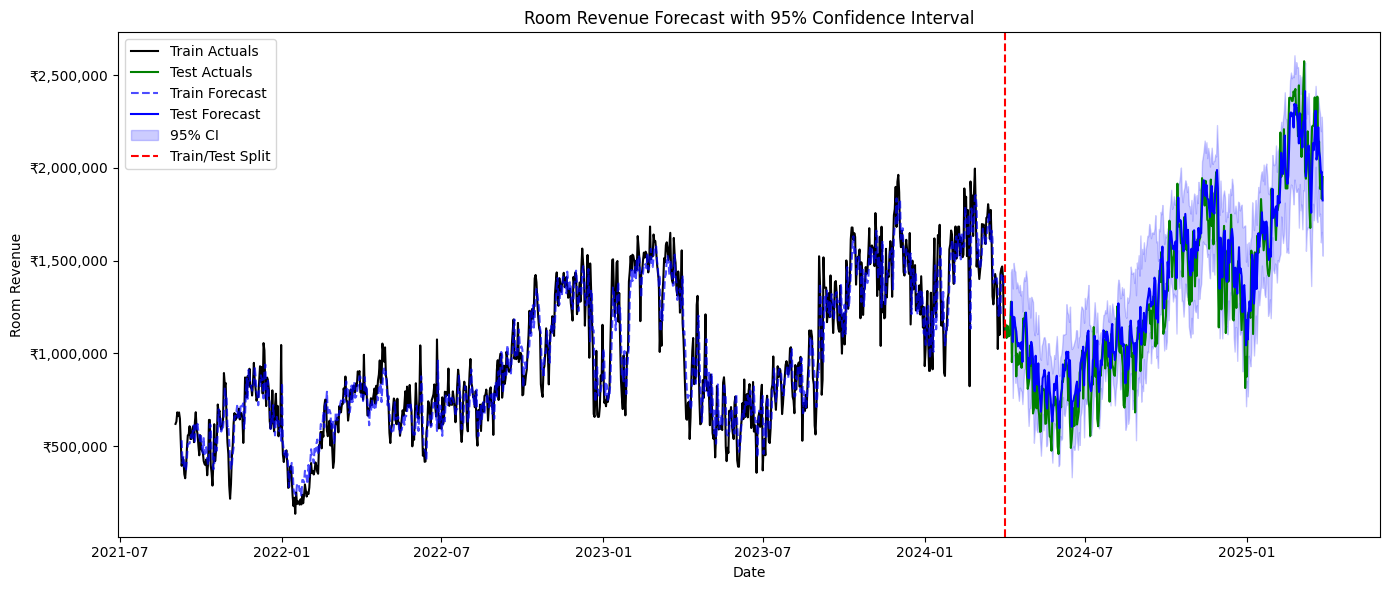

In [7]:
exog_cols = ['Arrival Rooms',  'Compliment Rooms', 'House Use', 'Individual Confirm', 'ARR', 'Departure Rooms']

prophet_df = prepare_prophet_data(
    merged_df,
    target_col='Room Revenue',
    exogenous_cols= exog_cols  # or pass your extra regressors
)
prophet_df = prophet_df[['ds', 'y']]

from neuralprophet import NeuralProphet, set_log_level
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import mean_squared_error

set_log_level("ERROR")
# -------------------------
# Train-test split (70/30 chronological)
# -------------------------
prophet_df.index = pd.to_datetime(prophet_df.index)

# Split based on date
train_df = prophet_df[prophet_df.index < '2024-04-01']
test_df  = prophet_df[prophet_df.index >= '2024-04-01']

# -------------------------
# Define NeuralProphet with exogenous regressors
# -------------------------
m = NeuralProphet(
    n_changepoints=10,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    n_lags=7,
    quantiles=[0.025, 0.5, 0.975]  # 95% CI
)

m.set_plotting_backend("matplotlib")

# Train the model
metrics = m.fit(train_df)

# Forecast for train & test
forecast_train = m.predict(train_df)
forecast_test = m.predict(test_df)

# -------------------------
# Plot forecast with 95% CI
# -------------------------
plt.figure(figsize=(14,6))

# Actuals
plt.plot(train_df['ds'], train_df['y'], 'k-', label="Train Actuals")
plt.plot(test_df['ds'], test_df['y'], 'g-', label="Test Actuals")

# Forecast median
plt.plot(forecast_train['ds'], forecast_train['yhat1'], 'b--', alpha=0.7, label="Train Forecast")
plt.plot(forecast_test['ds'], forecast_test['yhat1'], 'b-', label="Test Forecast")

# 95% CI
plt.fill_between(
    forecast_test['ds'],
    forecast_test['yhat1 2.5%'],
    forecast_test['yhat1 97.5%'],
    color='blue', alpha=0.2, label="95% CI"
)

# Vertical line for split point
plt.axvline(pd.to_datetime("2024-04-01"), color="red", linestyle="--", label="Train/Test Split")

# Format y-axis as currency
plt.gca().yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, p: f"₹{x:,.0f}")
)

plt.title("Room Revenue Forecast with 95% Confidence Interval")
plt.xlabel("Date")
plt.ylabel("Room Revenue")
plt.legend()
plt.tight_layout()
plt.show()


WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\data\process.py:496: FutureWarnin

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 11. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.

Finding best initial lr: 100%|██████████| 225/225 [00:03<00:00, 72.53it/s]


Training: |          | 0/? [00:45<?, ?it/s, v_num=138, train_loss=0.0137, reg_loss=0.000, MAE=1.02e+5, RMSE=1.35e+5, Loss=0.0139, RegLoss=0.000]

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARN


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.61it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARN

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\data\process.py:496: FutureWarnin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.74it/s]


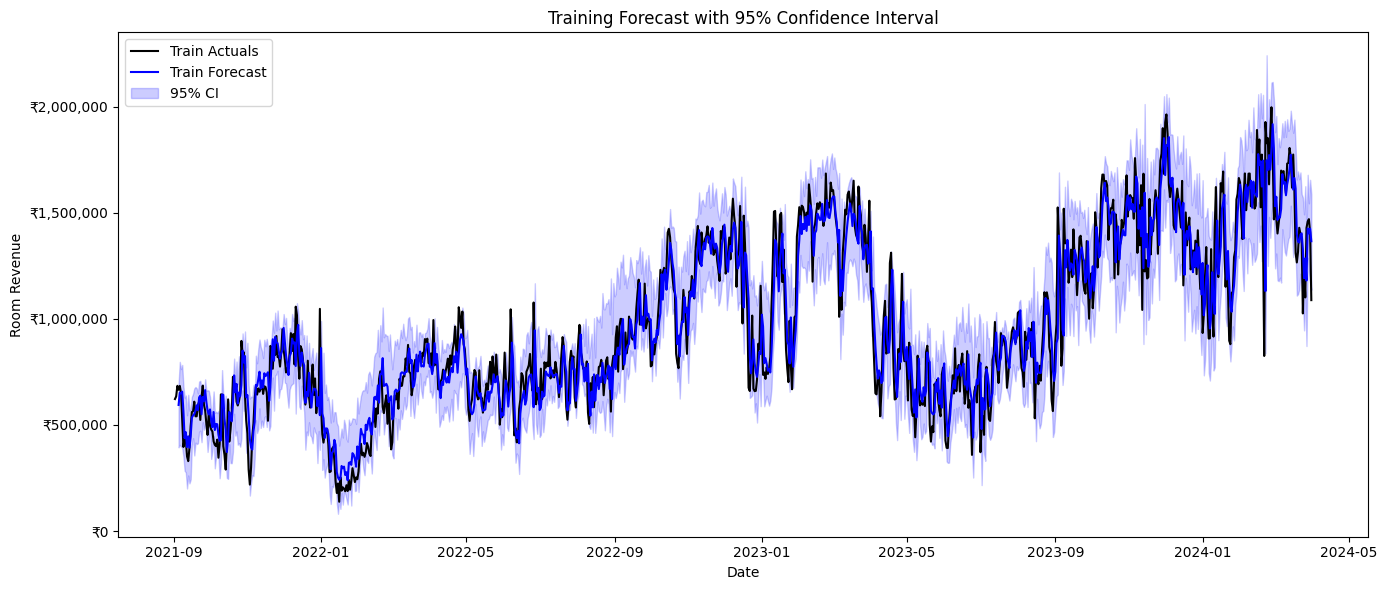

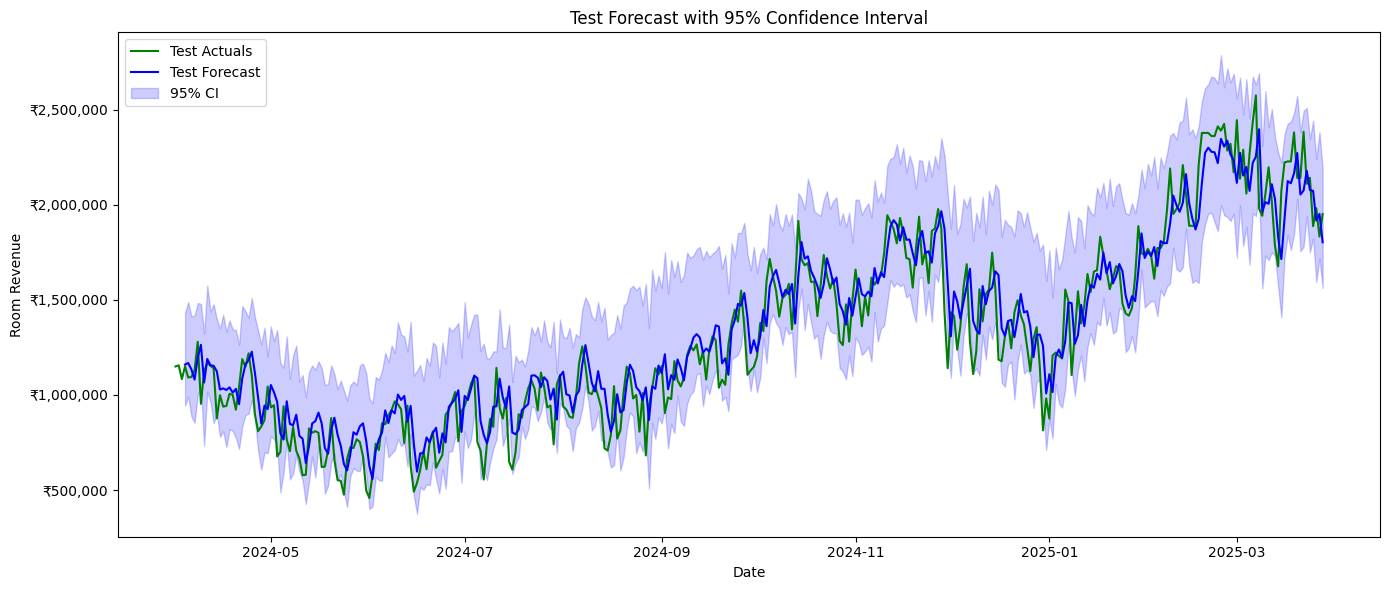

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from neuralprophet import NeuralProphet, set_log_level
from sklearn.metrics import mean_squared_error

set_log_level("ERROR")

# -------------------------
# Train-test split (70/30 chronological)
# -------------------------
prophet_df.index = pd.to_datetime(prophet_df.index)

train_df = prophet_df[prophet_df.index < '2024-04-01']
test_df  = prophet_df[prophet_df.index >= '2024-04-01']

# -------------------------
# Define NeuralProphet with exogenous regressors
# -------------------------
m = NeuralProphet(
    n_changepoints=10,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    n_lags=3,
    quantiles=[0.025, 0.5, 0.975]  # 95% CI
)

m.set_plotting_backend("matplotlib")

# Train model
metrics = m.fit(train_df)

# Forecast train & test
forecast_train = m.predict(train_df)
forecast_test = m.predict(test_df)

# -------------------------
# Plot TRAIN forecast
# -------------------------
plt.figure(figsize=(14,6))
plt.plot(train_df['ds'], train_df['y'], 'k-', label="Train Actuals")
plt.plot(forecast_train['ds'], forecast_train['yhat1'], 'b-', label="Train Forecast")

plt.fill_between(
    forecast_train['ds'],
    forecast_train['yhat1 2.5%'],
    forecast_train['yhat1 97.5%'],
    color='blue', alpha=0.2, label="95% CI"
)

plt.gca().yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, p: f"₹{x:,.0f}")
)

plt.title("Training Forecast with 95% Confidence Interval")
plt.xlabel("Date")
plt.ylabel("Room Revenue")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------
# Plot TEST forecast
# -------------------------
plt.figure(figsize=(14,6))
plt.plot(test_df['ds'], test_df['y'], 'g-', label="Test Actuals")
plt.plot(forecast_test['ds'], forecast_test['yhat1'], 'b-', label="Test Forecast")

plt.fill_between(
    forecast_test['ds'],
    forecast_test['yhat1 2.5%'],
    forecast_test['yhat1 97.5%'],
    color='blue', alpha=0.2, label="95% CI"
)

plt.gca().yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, p: f"₹{x:,.0f}")
)

plt.title("Test Forecast with 95% Confidence Interval")
plt.xlabel("Date")
plt.ylabel("Room Revenue")
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
# forecast

In [10]:
# forecast_test

In [11]:
import numpy as np

# Assuming forecast_test has columns 'y' (actual) and 'yhat1' (predicted)
mse = np.mean((forecast_test['y'] - forecast_test['yhat1'])**2)  # Mean Squared Error
rmse = np.sqrt(mse)  # Root Mean Squared Error

print('MSE:', mse)
print('RSME: ', rmse)
# print('RMSE:', rmse)


MSE: 22300358902.099377
RSME:  149333.04691895688


In [12]:
from sklearn.metrics import mean_squared_error

# -------------------------
# Forecast for train and test
# -------------------------
forecast_train = m.predict(train_df)
forecast_test  = m.predict(test_df)

# -------------------------
# Drop NaNs from yhat1
# -------------------------
valid_train = forecast_train.dropna(subset=['yhat1'])
valid_test  = forecast_test.dropna(subset=['yhat1'])

# Align actuals
train_actual = train_df['y'].iloc[-len(valid_train):]
test_actual  = test_df['y'].iloc[-len(valid_test):]


print('valid train',valid_train)
print('valid test',valid_test)

# -------------------------
# Compute MSE
# -------------------------
train_mse = mean_squared_error(train_actual, valid_train['yhat1'])
test_mse  = mean_squared_error(test_actual, valid_test['yhat1'])

print(f"📊 Train MSE: {train_mse:.2f}")
print(f"📊 Test  MSE: {test_mse:.2f}")


WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARN

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.49it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)



WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARN

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.00it/s]
valid train             ds          y         yhat1    yhat1 2.5%   yhat1 97.5%  \
3   2021-09-05   664046.0  5.926491e+05  3.927431e+05  6.935012e+05   
4   2021-09-06   682494.0  6.502216e+05  4.042840e+05  7.958282e+05   
5   2021-09-07   649119.0  6.476392e+05  3.970404e+05  7.619194e+05   
6   2021-09-08   518542.0  6.551939e+05  3.900600e+05  7.814512e+05   
7   2021-09-09   394551.0  5.630611e+05  3.506365e+05  6.800042e+05   
..         ...        ...           ...           ...           ...   
937 2024-03-27  1427730.0  1.179270e+06  8.703551e+05  1.417613e+06   
938 2024-03-28  1457687.0  1.424652e+06  1.286789e+06  1.678138e+06   
939 2024-03-29  1468948.0  1.401814e+06  1.219708e+06  1.543555e+06   
940 2024-03-30  1407306.0  1.423924e+06  1.170275e+06  1.654246e+06   
941 2024-03-31  1086947.0  1.364863e+06  1.135556e+06  1.585582e+06   

               ar1         trend  season_yearly  season_weekly 

In [13]:
# m.plot(forecast_train) 
# m.plot(forecast_test)

In [14]:
from neuralprophet import NeuralProphet

# Prepare data with only the regressors we'll actually use
regressor_cols = ['Arrival Rooms', 'Departure Rooms', 'House Use', 'Individual Confirm']

prophet_df = prepare_prophet_data(
    merged_df,
    target_col='Room Revenue',
    exogenous_cols=regressor_cols  # Only include regressors we'll use
)

# Keep only ds, y, and the regressor columns we need
prophet_df = prophet_df[['ds', 'y'] + regressor_cols]

# Initialize model
m = NeuralProphet(
    n_changepoints=10,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    n_lags=7,  # Uses past 7 days of target variable
)

# Example 1: Add LAGGED regressors (uses past values)
# Good for variables where past values influence future revenue
for col in ['Arrival Rooms', 'Departure Rooms']:
    m = m.add_lagged_regressor(col, n_lags=3)  # Use past 3 days

# Example 2: Add FUTURE regressors (uses current/future values)  
# Good for planned/scheduled variables you know in advance
for col in ['House Use', 'Individual Confirm']:
    m = m.add_future_regressor(col)

print("Data shape:", prophet_df.shape)
print("Columns:", prophet_df.columns.tolist())

WARNING - (py.warnings._showwarnmsg) - C:\Users\jnami\AppData\Local\Temp\ipykernel_77736\524623030.py:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prophet_df.fillna(method='bfill', inplace=True)

WARNING - (py.warnings._showwarnmsg) - C:\Users\jnami\AppData\Local\Temp\ipykernel_77736\524623030.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prophet_df.fillna(method='ffill', inplace=True)



Data shape: (1304, 6)
Columns: ['ds', 'y', 'Arrival Rooms', 'Departure Rooms', 'House Use', 'Individual Confirm']


In [15]:
# -------------------------
# Train-test split (70/30 chronological)
# -------------------------
prophet_df.index = pd.to_datetime(prophet_df.index)

# Split based on date
train_df = prophet_df[prophet_df.index < '2024-04-01']
test_df  = prophet_df[prophet_df.index >= '2024-04-01']

print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Train period: {train_df.index.min()} to {train_df.index.max()}")
print(f"Test period: {test_df.index.min()} to {test_df.index.max()}")

Train data shape: (942, 6)
Test data shape: (362, 6)
Train period: 2021-09-02 00:00:00 to 2024-03-31 00:00:00
Test period: 2024-04-01 00:00:00 to 2025-03-28 00:00:00


In [16]:
# -------------------------
# Train the model on training data
# -------------------------
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Train model with regressors
m.set_plotting_backend("matplotlib")
# set_log_level("ERROR")

print("Training model with lagged and future regressors...")
metrics = m.fit(train_df)
print("Training completed!")

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():



Training model with lagged and future regressors...


WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\data\process.py:496: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_grouped = df.groupby("ID").apply(lambda x: x.set_index("ds").resample(freq).asfreq()).drop(columns=["ID"])

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\ne

Epoch 120: 100%|██████████| 120/120 [00:02<00:00, 54.91it/s]   
Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 225/225 [00:03<00:00, 70.57it/s]


Training: |          | 0/? [00:54<?, ?it/s, v_num=139, train_loss=0.00888, reg_loss=0.000, MAE=7.71e+4, RMSE=1.12e+5, Loss=0.00875, RegLoss=0.000]
Training completed!


In [17]:
# -------------------------
# Make predictions on train and test data
# -------------------------
print("Making predictions...")
forecast_train = m.predict(train_df)
forecast_test = m.predict(test_df)

print("Train forecast shape:", forecast_train.shape)
print("Test forecast shape:", forecast_test.shape)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)



WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\data\split.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_i = pd.concat([df_i, future_df])

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use `

Making predictions...
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 41.51it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARN

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\data\process.py:496: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_grouped = df.groupby("ID").apply(lambda x: x.set_index("ds").resample(freq).asfreq()).drop(columns=["ID"])

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\data\process.py:507: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns afte

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.98it/s] 
Train forecast shape: (941, 13)
Test forecast shape: (361, 13)


In [18]:
# -------------------------
# Calculate performance metrics
# -------------------------
# Drop NaNs from predictions
valid_train = forecast_train.dropna(subset=['yhat1'])
valid_test = forecast_test.dropna(subset=['yhat1'])

# Align actual values with valid predictions
train_actual = train_df['y'].iloc[-len(valid_train):]
test_actual = test_df['y'].iloc[-len(valid_test):]

# Calculate metrics
train_mse = mean_squared_error(train_actual, valid_train['yhat1'])
test_mse = mean_squared_error(test_actual, valid_test['yhat1'])
train_mae = mean_absolute_error(train_actual, valid_train['yhat1'])
test_mae = mean_absolute_error(test_actual, valid_test['yhat1'])

print(f"📊 MODEL PERFORMANCE WITH REGRESSORS:")
print(f"Train MSE: {train_mse:.2f}")
print(f"Test MSE:  {test_mse:.2f}")
print(f"Train MAE: {train_mae:.2f}")
print(f"Test MAE:  {test_mae:.2f}")
print(f"Train RMSE: {np.sqrt(train_mse):.2f}")
print(f"Test RMSE:  {np.sqrt(test_mse):.2f}")

📊 MODEL PERFORMANCE WITH REGRESSORS:
Train MSE: 28103989372.20
Test MSE:  39715315318.59
Train MAE: 122689.51
Test MAE:  157081.15
Train RMSE: 167642.45
Test RMSE:  199287.02


WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\plot_forecast_matplotlib.py:84: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ds = fcst["ds"].dt.to_pydatetime()



Plotting training results...


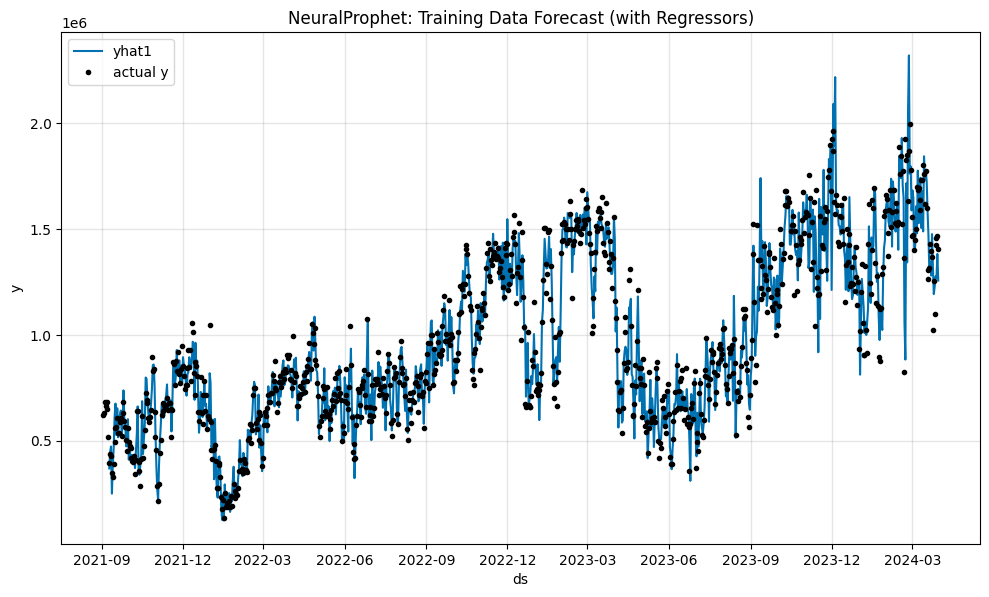

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\plot_forecast_matplotlib.py:84: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ds = fcst["ds"].dt.to_pydatetime()



Plotting test results...


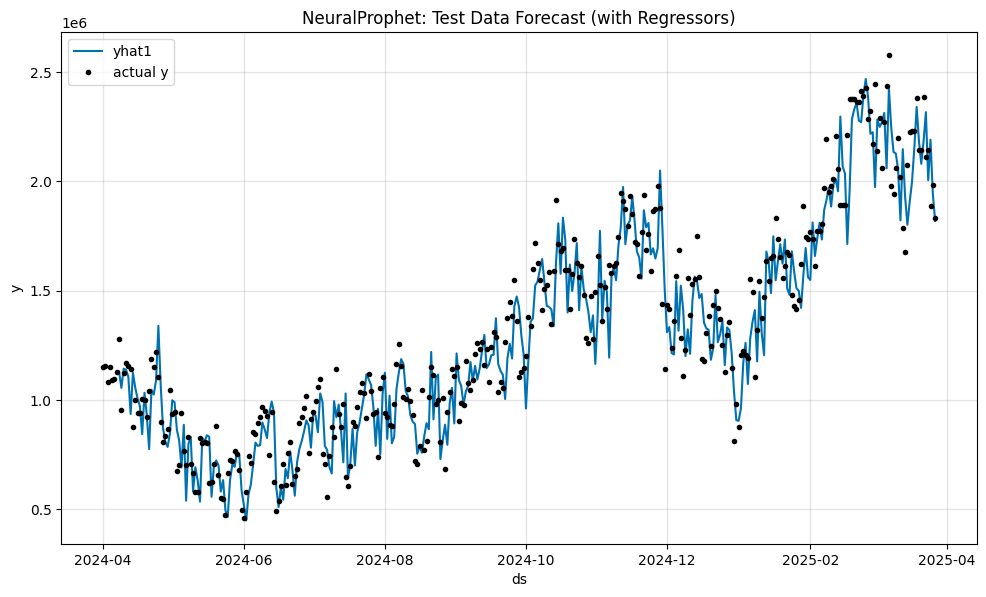

In [19]:
# -------------------------
# Visualize results
# -------------------------
# Plot training predictions
print("Plotting training results...")
fig_train = m.plot(forecast_train)
plt.title("NeuralProphet: Training Data Forecast (with Regressors)")
plt.show()

# Plot test predictions
print("Plotting test results...")
fig_test = m.plot(forecast_test)
plt.title("NeuralProphet: Test Data Forecast (with Regressors)")
plt.show()

In [20]:
# # -------------------------
# # Demonstrate difference between lagged vs future regressors
# # -------------------------
# print("\n🔍 UNDERSTANDING REGRESSOR DIFFERENCES:")
# print("\n1. LAGGED REGRESSORS (Arrival Rooms, Departure Rooms):")
# print("   - Use PAST values (n_lags=3 days)")
# print("   - Can forecast without knowing future regressor values")
# print("   - Captures delayed effects on revenue")

# print("\n2. FUTURE REGRESSORS (House Use, Individual Confirm):")
# print("   - Use CURRENT/FUTURE values")
# print("   - Need future regressor values to make forecasts")
# print("   - Captures immediate/planned effects on revenue")

# # -------------------------
# # Future forecasting capability
# # -------------------------
# print("\n📈 FORECASTING CAPABILITIES:")

# # For demonstration: Create future dates
# future_df = m.make_future_dataframe(prophet_df, periods=30)

# print(f"Original data ends: {prophet_df['ds'].max()}")
# print(f"Future forecast until: {future_df['ds'].max()}")

# # Note: For future regressors, you would need to provide future values
# print("\n⚠️  Note: To forecast with future regressors, you need to provide future values")
# print("   For lagged regressors, forecasting works automatically with historical data")